# Testing different Hyperparameters and Benchmarking

In this notebook, we'll cover how to test different hyperparameters for a particular dataset and how to benchmark different parameters across a group of datasets.

## Table of Contents

* [Testing parameter](#hyperparam)
  * [Using Python](#python)
  * [Using the CLI](#cli)
  * [Visualizing the results](#visualize)
* [Benchmarking parameters](#benchmarking)

---

## Testing hyperparameters  <a name="hyperparam"></a>

Lets say we want to learn more about __how different learning rates and different image sizes affect our model's accuracy when restricted to 10 epochs__, and we want to build an experiment to test out these hyperparameters.

In this notebook, we'll walk through how we use out Parameter Sweeper module with the following:

- use python to perform this experiment
- use the CLI to perform this experiment
- evalute the results using Pandas

We start by importing the utilities we need.

In [1]:
import sys
sys.path.append("../")
import os

from utils_ic.common import ic_root_path
from utils_ic.datasets import unzip_url, Urls
from utils_ic.parameter_sweeper import *

Download some data that we want to test on. To use the Parameter Sweeper tool for single label classification, we'll need to make sure that the data is stored such that images are sorted into their classes inside of a subfolder. In this notebook, we'll use the Fridge Objects dataset provided in `utils_ic.datasets.Urls`, which is stored in the correct format.

We also define some parameters we will use in this notebook

In [2]:
DATA = unzip_url(Urls.fridge_objects_path, exist_ok=True)
REPS = 3
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
IM_SIZES = [299, 499]
EPOCHS = [10]

### Using Python <a name="python"></a>

We start by creating the Parameter Sweeper object:

In [3]:
sweeper = ParameterSweeper()

Before we start testing, it's a good idea to see what the default parameters Are. We can use a the property `parameters` to easily see those default values.

In [4]:
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7f23363d4730>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True])])

Now that we know the defaults, we can pass it the parameters we want to test. 

In this notebook, we want to see the effect of different learning rates across different image sizes using only 8 epochs (the default number of epochs is 15). To do so, I would run the `update_parameters` functions as follows:

```python
sweeper.update_parameters(learning_rate=[1e-3, 1e-4, 1e-5], im_size=[299, 499], epochs=[10])
```

Notice that all parameters must be passed in as a list, including single values such the number of epochs.

These parameters will be used to calculate the number of permutations to run. In this case, we've pass in three options for learning rates, two for image sizes, and one for number of epochs. This will result in 3 X 2 X 1 total permutations (in otherwords, 6 permutations). 

In [5]:
sweeper.update_parameters(learning_rate=LEARNING_RATES, im_size=IM_SIZES, epochs=EPOCHS)

Now that we have our parameters defined, we call the `run()` function with the dataset to test on. 

We can also optionally pass in:
- the number of repetitions to run each permutation (default is 3)
- whether or not we want the training to stop early if the metric (accuracy) doesn't improve by 0.01 (1%) over 3 epochs (default is False)

The `run` function returns a multi-index dataframe which we can work with right away.

In [6]:
df = sweeper.run(datasets=[DATA], reps=REPS); df

this Learner object self-destroyed - it still exists, but no longer usable


duration  \
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  16.630860   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  25.982370   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  21.550776   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  27.224495   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  16.799283   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  26.279059   
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  16.783818   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  26.038197   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  16.770078   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  26.136180   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  16.874532   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  26.539296   
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  16.956139   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  26.314672   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  16.884989   
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  25.947570   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  17.115705   
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  26.203381   

                                                                    accuracy  
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.818182  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.795455  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.340909  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.363636  
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.840909  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.818182  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.863636  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.886364  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.363636  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.363636  
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.909091  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 10]... fridgeObjects  0.931818  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.909091  
  PARAMETERS [learning_rate: 0.001]|[epochs: 10]|... fridgeObjects  0.931818  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.409091  
  PARAMETERS [learning_rate: 1e-05]|[epochs: 10]|... fridgeObjects  0.500000

### Using the CLI <a name="cli"></a>

Instead of using python to run this experiment, we may want to test from the CLI. We can do so by using the `scripts/benchmark.py` file. 

First we move up to the `/image_classification` directory.

In [7]:
os.chdir(ic_root_path())

To reproduce the same test (different learning rates across different image sizes using only 8 epochs), and the same settings (3 repetitions, and no early_stopping) we can run the following:

```sh
python scripts/sweep.py 
    --learning-rates 1e-3 1e-4 1e-5
    --im-size 99 299
    --epochs 5 
    --repeat 3 
    --no-early-stopping 
    --inputs <my-data-dir>
    --output lr_bs_test.csv
```

Additionally, we've added an output parameter, which will automatically dump our dataframe into a csv file.

To simplify the command, we can use the acryonyms of the params. We can also remove `--no-early-stopping` as that is the default behavior.

```sh
python scripts/sweep.py -lr 1e-3 1e-4 1e-5 -is 99 299 -e 5 -i <my-data-dir> -o lr_bs_test.csv
```

Once the script completes, load the csv into a dataframe to explore it's contents. We'll want to specify `index_col=[0, 1, 2]` since it is a multi-index dataframe.

```python
df = pd.read_csv("data/lr_bs_test.csv", index_col=[0, 1, 2])
```

> HINT: You can learn more about how to use the script with the `--help` flag.

In [14]:
!{sys.executable} scripts/sweep.py --help

usage: sweep.py [-h] [--learning-rate LEARNING_RATES [LEARNING_RATES ...]]
                [--epoch EPOCHS [EPOCHS ...]]
                [--batch-size BATCH_SIZES [BATCH_SIZES ...]]
                [--im-size IM_SIZES [IM_SIZES ...]]
                [--architecture {squeezenet1_1,resnet18,resnet34,resnet50} [{squeezenet1_1,resnet18,resnet34,resnet50} ...]]
                [--transform TRANSFORMS [TRANSFORMS ...]]
                [--dropout DROPOUTS [DROPOUTS ...]]
                [--weight-decay WEIGHT_DECAYS [WEIGHT_DECAYS ...]]
                [--training-schedule {head_only,body_only,head_first_then_body} [{head_only,body_only,head_first_then_body} ...]]
                [--discriminative-lr {True,False} [{True,False} ...]]
                [--one-cycle-policy ONE_CYCLE_POLICIES [ONE_CYCLE_POLICIES ...]]
                (--inputs INPUTS [INPUTS ...] | --benchmark)
                [--early-stopping] [--repeat REPEAT] [--output OUTPUT]
                [--clean-up]

This script is used t

### Visualize Results <a name="visualize"></a>

When we read in out multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset.

To see the results, show the df using the `clean_sweeper_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [15]:
df = clean_sweeper_df(df)

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [16]:
df.mean(level=(1,2)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects
duration,16.790272,26.111746,18.401948,26.436082,16.929840,26.340579
accuracy,0.856061,0.901515,0.909091,0.871212,0.371212,0.409091


Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets. (The results of this step will look similar to the above since we're only passing in one dataset).

In [17]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001] [im_size: 299],P: [learning_rate: 0.0001] [im_size: 499],P: [learning_rate: 0.001] [im_size: 299],P: [learning_rate: 0.001] [im_size: 499],P: [learning_rate: 1e-05] [im_size: 299],P: [learning_rate: 1e-05] [im_size: 499]
duration,16.790272,26.111746,18.401948,26.436082,16.929840,26.340579
accuracy,0.856061,0.901515,0.909091,0.871212,0.371212,0.409091


To make it easier to see which permutation did the best, we can plot the results using the `plot_sweeper_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

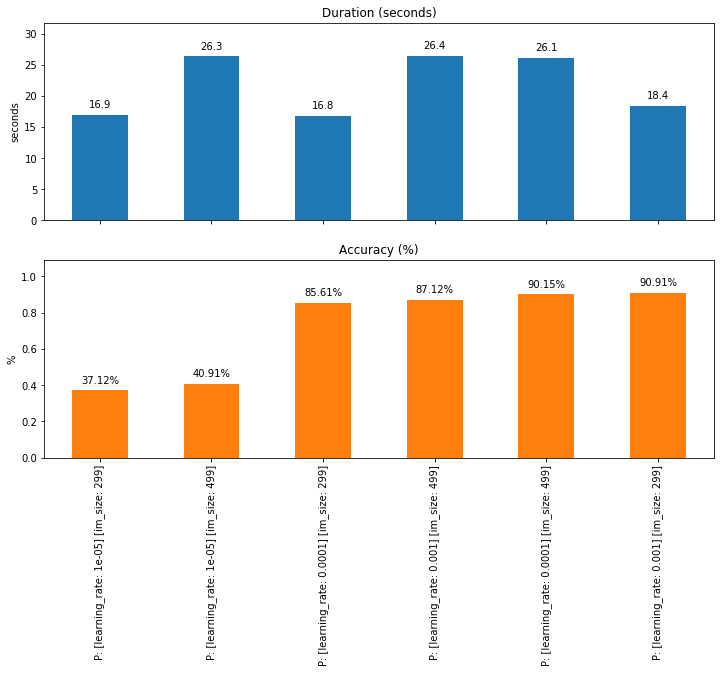

In [18]:
plot_sweeper_df(df.mean(level=(1)), sort_by="accuracy")

---

## Benchmarking <a name="benchmarking"></a>

We can also use the Parameter Sweeper module to perform some benchmarking on different paramters. Let's say we're interesting in understanding what a good learning rate is given some arbitrary dataset. 

To answer the question, we use the Parameter Sweeper. However, instead of passing in a single dataset as we did above, we can use a grouping of datasets (which we can simply get from `unzip_urls(Urls.all())`) so that we can tell how well the paramters do across different datasets.

In [2]:
BENCHMARK_DATA = unzip_urls(Urls.all())
BENCHMARK_LEARNING_RATES = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
BENCHMARK_EPOCHS = [3]
BENCHMARK_REPS = 5

Next, create a new Parameter Sweeper object to use.

In [3]:
benchmarking_sweeper = ParameterSweeper()

Set the parameter we want to test on.

In [5]:
benchmarking_sweeper.update_parameters(learning_rate=BENCHMARK_LEARNING_RATES, epochs=BENCHMARK_EPOCHS)

This time when we run the benchmark, it will test across all the datasets we've passed in. This will give us a sense of how these parameters work given an arbitrary dataset.

In [7]:
df = benchmarking_sweeper.run(datasets=BENCHMARK_DATA, reps=BENCHMARK_REPS)

> Doing a benchmark can also be done using the CLI with the __scripts/sweep.py__ file. The only difference is that we use the `--benchmark` flag that will automatically use the curated set of 6 datasets that are used when calling `Urls.all()`.
> ```sh
python scripts/sweep.py -lr 1e-2 1e-3 1e-4 1e-5 1e-6 --benchmark --output <output_results.csv>
```

### Visualize Results
Like before, we'll now want to visualize these results. First we use the `clean_sweeper_df` helper function to clean up our dataframe from redundant parameter strings.

In [8]:
df = clean_sweeper_df(df)

Like before, we can see the averages over the different __runs__.

In [9]:
df.mean(level=(1,2)).T

P: [learning_rate: 0.0001]                                    \
                     fashionTexture flickrLogos32Subset food101Subset   
duration                  63.417779           80.348700     58.075464   
accuracy                   0.825442            0.720575      0.905454   

                                            P: [learning_rate: 0.001]  \
         fridgeObjects   lettuce recycle_v3            fashionTexture   
duration      5.167652  6.665957  18.713919                 63.939942   
accuracy      0.713636  0.827200   0.950538                  0.772791   

                                                          ...  \
         flickrLogos32Subset food101Subset fridgeObjects  ...   
duration           80.848514     58.162088      5.134694  ...   
accuracy            0.820797      0.887879      0.822727  ...   

         P: [learning_rate: 1e-05]                                     \
                     food101Subset fridgeObjects   lettuce recycle_v3   
duration                 58.332290      5.136389  6.665299  18.678736   
accuracy                  0.743636      0.290909  0.585600   0.539785   

         P: [learning_rate: 1e-06]                                    \
                    fashionTexture flickrLogos32Subset food101Subset   
duration                 63.872168           80.460484     58.149106   
accuracy                  0.113074            0.037168      0.296727   

                                             
         fridgeObjects   lettuce recycle_v3  
duration      5.152301  6.619845  18.605217  
accuracy      0.304545  0.456000   0.167204  

[2 rows x 30 columns]

We can also see the averages over the different __datasets__ too.

In [10]:
df.mean(level=(1)).T

,P: [learning_rate: 0.0001],P: [learning_rate: 0.001],P: [learning_rate: 0.01],P: [learning_rate: 1e-05],P: [learning_rate: 1e-06]
duration,38.731578,38.903957,38.900608,38.643917,38.809853
accuracy,0.823808,0.846394,0.393808,0.455115,0.229120


Print the average accuracy over the different runs for each dataset independently.

[Text(0, 0, '0.00%'),
 Text(0, 0, '20.00%'),
 Text(0, 0, '40.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '80.00%'),
 Text(0, 0, '100.00%'),
 Text(0, 0, '120.00%')]

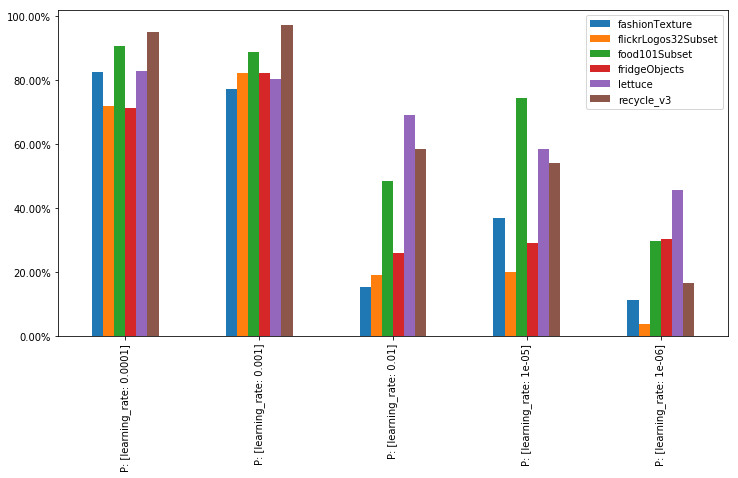

In [11]:
ax = df.mean(level=(1,2))["accuracy"].unstack().plot(kind='bar', figsize=(12, 6))
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])

Take advantage of the helper function `plot_sweeper_df` to visualize the results in a nice way.

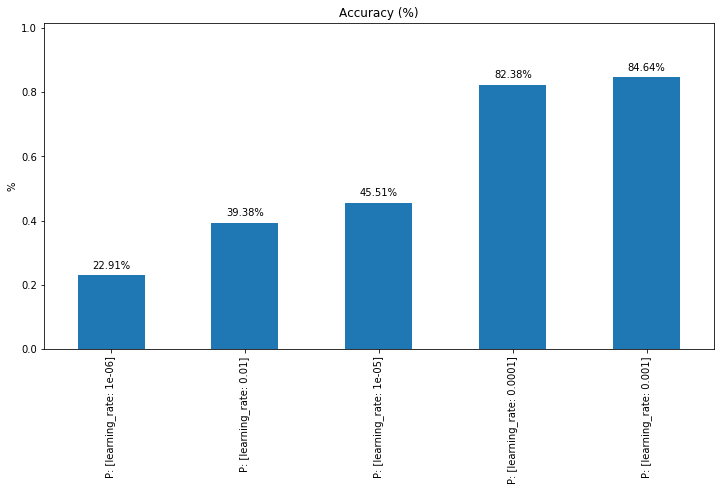

In [12]:
plot_sweeper_df(df.mean(level=(1)), sort_by="accuracy", show_cols=["accuracy"], figsize=(12,6))